# Examen Python data developer
# Deel 1
## Introductie
Voor dit examen is het belangrijk dat je volgende zaken zeker doet:
 - Maak een Vitual Environment aan & exporteer een `.yml` (of soortgelijke) file aan die je toevoegt aan je codebase.
 - Maak een github pagina aan met een bijhorende `.gitignore` en `readme.md`. Voeg een link naar de github repo toe aan je readme file.
 - Zorg dat je op het einde de tijd neemt om je code op te schonen zodat deze begrijpelijk is voor derden.
 - Wanneer je klaar bent, maak een `.zip` bestand van je volledige codebase aan en laad deze op in de leeromgeving.

In deze opgave bekijken we een gesimuleerde dataset over de geboortes in België van 2019. De data is te vinden in `.csv` bestanden die gelabeld zijn met de echte geboortedag van de personen in het bestand. Laat ons bijvoorbeeld even kijken naar de eerste 5 lijnen van het bestand `2019-1-1.csv`:

<table align="center">
  <tr>
    <th>gemeente</th>
    <th>naam</th>
    <th>geslacht</th>
    <th>verwachte datum</th>
  </tr>
  <tr>
    <td>Hooglede</td>
    <td>Elias</td>
    <td>Mannelijk</td>
    <td>01/14/2019</td>
  </tr>
  <tr>
    <td>Sint-Niklaas (Sint-Niklaas)</td>
    <td>Pauline</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Wijnegem</td>
    <td>Anita</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Grâce-Hollogne</td>
    <td>Jean-Paul</td>
    <td>Mannelijk</td>
    <td>01/13/2019</td>
  </tr>
  <tr>
    <td>Boussu</td>
    <td>François</td>
    <td>Mannelijk</td>
    <td>01/26/2019</td>
  </tr>
</table>


Hier hebben we de kolommen:
 - **gemeente**: De gemeente waar de persoon geboren is.
 - **naam**: De voornaam van de persoon.
 - **geslacht**: Het geslacht van de persoon (Mannelijk of Vrouwelijk).
 - **verwachte datum**: De verwachte geboortedatum van de persoon.

Dus hier hebben we dan bijvoorbeeld op de eerste lijn de mannelijke persoon Elias die geboren is in Hooglede waarvan men verwachtte dat hij zou geboren worden op `01/14/2019` (Amerikaans formaat) maar in feite geboren is op 1 januari 2019.

Doorheen deze opgave gaan we de data van dichterbij inspecteren! Je kan deze opgaves alternatief lezen in de bijgeleverde notebook `examen.ipynb` waar ook de (meeste) afbeeldingen & resultaten zichtbaar zijn.

In [360]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Utilities

In [361]:
def to_percentage(number):
    return str(np.round(number * 100, 2)) + "%"

def compute_num_unique(df, n_births):
    return len(np.unique(df['naam'].sample(n_births)))

## Stap 1: data inlezen

Maak een lus over alle bestanden in de map `data/geboortes`, lees elk `.csv` bestand in en voeg deze samen tot 1 grote DataFrame. Merk op dat de datum verwerkt zit in de filename, voeg deze toe aan de kleine DataFrames voor je de dataframes samenvoegt met een `pd.concat(dfs)`.

Voeg een extra kolom toe met een `"dag van het jaar"` getal, dus 1 januari 2019 is `1`, 2 januari 2019 is `2`, enzovoort.

**Opmerking**: Er is ook data voor 29 februari 2019, terwijl dit geen schrikkeljaar is! Plaats deze geboortes in een afzonderlijke DataFrame `df_wrong`. Zet in `df_wrong` een extra kolom met een referentie naar waarom deze data foutief is.

### Data Inlezen

In [382]:
loc_input_files = os.path.join('..', 'data', 'input')

dfs = list()
for filename in os.listdir(loc_input_files):
    df = pd.read_csv(os.path.join(loc_input_files,filename))
    df['datum'] = filename.strip('.csv')
    dfs.append(df)

df_raw = pd.concat(dfs, ignore_index=True)
df = df_raw.copy()

## Preprocessing

In [381]:
def clean_df(df):
    # df_wrong met verkeerde datum (29 februari)
    df_wrong = df[df['datum'] == '2019-2-29'].copy()
    df_wrong['nota'] = '2019 is geen schrikkelijkjaar'

    # Verwijder rijen met verkeerde datum (29 februari)
    df = df[df['datum'] != '2019-2-29'].copy()
    
    df['dag van het jaar'] = pd.to_datetime(df['datum']).dt.dayofyear
    df['verwachte datum'] = pd.to_datetime(df['verwachte datum'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')

    return df, df_wrong

In [380]:
geboortes, df_wrong = clean_df(df)

## Stap 2: Dagelijks aantal geboortes bekijken
#### Vraag 1: Maak een plot van het aantal geboortes per dag van het jaar. 

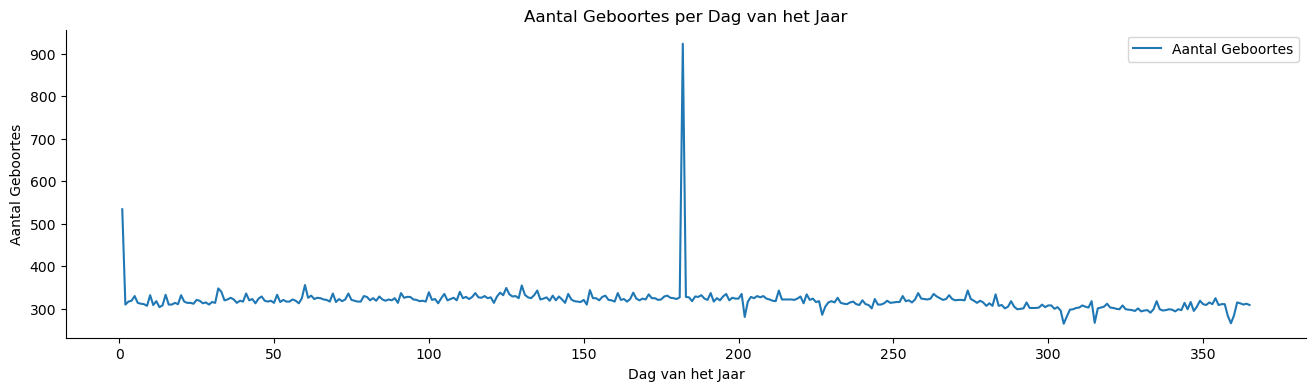

In [379]:
fig, ax = plt.subplots(figsize=(16, 4))

(geboortes.groupby(['dag van het jaar'])
            .size()
            .plot(ax = ax, label = 'Aantal Geboortes'))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Aantal Geboortes per Dag van het Jaar')
ax.set_xlabel('Dag van het Jaar')
ax.set_ylabel('Aantal Geboortes')
ax.legend();

##

#### Vraag 2: Outliers vinden & behandelen

We klassificeren een datum als een outlier als het aantal geboortes meer dan `50%` afwijkt van de gemiddelde waarde overheen de volledige dataset. Zoek alle outliers in de dataset.

In [383]:
limiet_grens = 0.5

geboortes_per_dag = (pd.DataFrame(geboortes.groupby(['dag van het jaar']).size(), 
                                  columns = ['aantal geboortes']).reset_index()).copy()

boven_limiet = geboortes_per_dag.mean() + geboortes_per_dag.mean()*limiet_grens
onder_limiet = geboortes_per_dag.mean() - geboortes_per_dag.mean()*limiet_grens

outliers_day_of_year = list()
for index, aantal in enumerate(geboortes_per_dag['aantal geboortes']):
    if aantal > boven_limiet['aantal geboortes']:
        outliers_day_of_year.append(geboortes_per_dag.iloc[index]['dag van het jaar'])
    elif aantal < onder_limiet['aantal geboortes']:
        outliers_day_of_year.append(geboortes_per_dag.iloc[index]['dag van het jaar'])

geboortes[geboortes['dag van het jaar'].isin(outliers_day_of_year)]['datum'].value_counts()


datum
2019-7-1    923
2019-1-1    534
Name: count, dtype: int64

Ik zal je vertellen; de outliers op 1 januari en 1 juli komen doordat alle geboortes waarvoor de datum niet correct genoteerd is, de datum 1 januari (voor de eerste helft van het jaar) en op 1 juli (voor de tweede helft van het jaar) geplaatst worden. Om dit op te lossen, halen we in de grote geboortes DataFrame (met 1 lijn per geboorte) deze twee datums er volledig uit. Dus we gaan **alle** geboortes van 1 januari en 1 juli verwijderen uit deze dataframe en toevoegen aan de `df_wrong` dataframe met als reden `2019-01-01` en `2019-07-01`.

In [374]:
geboortes_correct = geboortes.loc[~geboortes['dag van het jaar'].isin(outliers_day_of_year)].copy()
geboortes_fout = geboortes.loc[geboortes['dag van het jaar'].isin(outliers_day_of_year)].copy()
geboortes_fout.loc[:, 'nota'] = geboortes_fout['datum']
df_wrong = pd.concat([df_wrong, geboortes_fout], ignore_index=True)
df_wrong = df_wrong.drop(columns=['dag van het jaar'])

Maak dezelfde plot nu opnieuw met het aantal geboortes per dag.

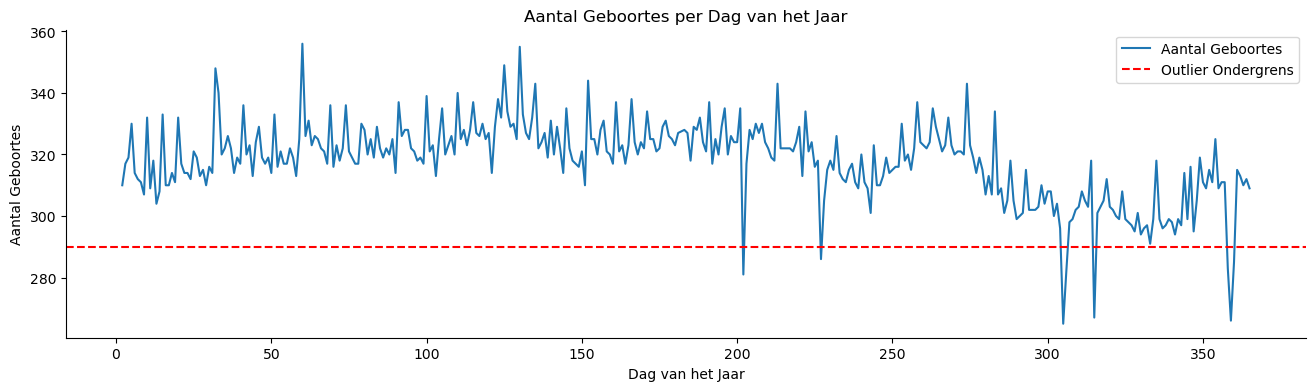

In [375]:
outlier_limiet = (geboortes_correct.groupby(['dag van het jaar'])
                                .size()
                                .mean() 
                                - 2.2*geboortes_correct.groupby(['dag van het jaar'])
                                .size()
                                .std())

fig, ax = plt.subplots(figsize=(16, 4))

(geboortes_correct.groupby(['dag van het jaar'])
            .size()
            .plot(ax = ax, label = 'Aantal Geboortes'))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Aantal Geboortes per Dag van het Jaar')
ax.set_xlabel('Dag van het Jaar')
ax.set_ylabel('Aantal Geboortes')
ax.axhline(outlier_limiet, color='r', linestyle='--', label='Outlier Ondergrens')
ax.legend();

 We zien dat er nog steeds redelijk wat uitschieters zijn, kan je code schrijven om de 5 extreme uitschieters in de 2e helft van het jaar identificeren (in totaal 8 datums)?

In [376]:
geboortes_per_dag_correct = (pd.DataFrame(geboortes_correct.groupby(['dag van het jaar']).size(), 
                                          columns = ['aantal geboortes'])
                                          .reset_index()).copy()
outlier_limiet = (geboortes_per_dag_correct['aantal geboortes'].mean() 
                  - 2.2*geboortes_per_dag_correct['aantal geboortes'].std())

outliers_year = list()
for index, aantal in enumerate(geboortes_per_dag_correct['aantal geboortes']):
    if aantal < outlier_limiet:
        outliers_year.append(geboortes_per_dag_correct.iloc[index]['dag van het jaar'])

(geboortes[geboortes['dag van het jaar'].isin(outliers_year)][['datum','dag van het jaar']]
                    .value_counts()
                    .reset_index()
                    .rename(columns={'count': 'aantal geboortes'}))

,datum,dag van het jaar,aantal geboortes
0,2019-8-15,227,286
1,2019-12-26,360,285
2,2019-12-24,358,283
3,2019-11-2,306,282
4,2019-7-21,202,281
5,2019-11-11,315,267
6,2019-12-25,359,266
7,2019-11-1,305,265


### Bonusvraag: wekelijkse verbanden

We zien vele pieken en dalen in de evolutie van het aantal geboortes. We willen deze grafiek graag iets "gladder" maken. Kan je hiervoor eens een visualizatie maken van het **gemiddeld** aantal geboortes per week (dit voor elke week, dus maandag-maandag, dinsdag-dinsdag, woensdag-woensdag, ...).

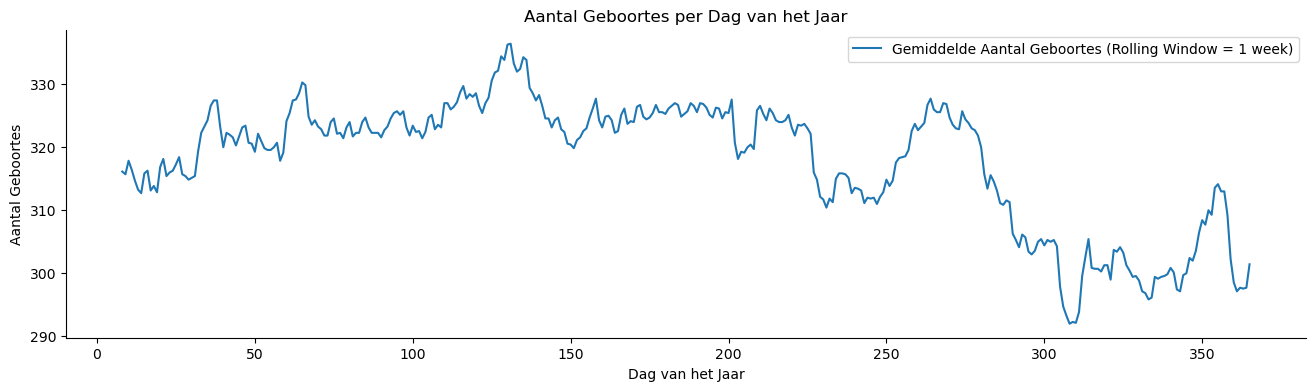

In [393]:
fig, ax = plt.subplots(figsize=(16, 4))

# rollow window size for a week
window_size = 7

# Calculate the mean number of births for each day of the week with a rolling window
gemiddelde_geboortes = (geboortes_correct.groupby('dag van het jaar')
                                .size()
                                .rolling(window_size)
                                .mean())

# Plot the results
gemiddelde_geboortes.plot(ax=ax, label='Gemiddelde Aantal Geboortes (Rolling Window = 1 week)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Aantal Geboortes per Dag van het Jaar')
ax.set_xlabel('Dag van het Jaar')
ax.set_ylabel('Aantal Geboortes')
ax.legend();

Dat ziet er al een stuk mooier uit!  We zien ook een aantal duidelijk dips & pieken verschijnen die we eerder niet zagen. We kunnen nu ook even kijken naar het gemiddeld aantal geboortes per dag van de week! Misschien worden er wel gewoon veel minder mensen geboren op zondag dan een andere dag?

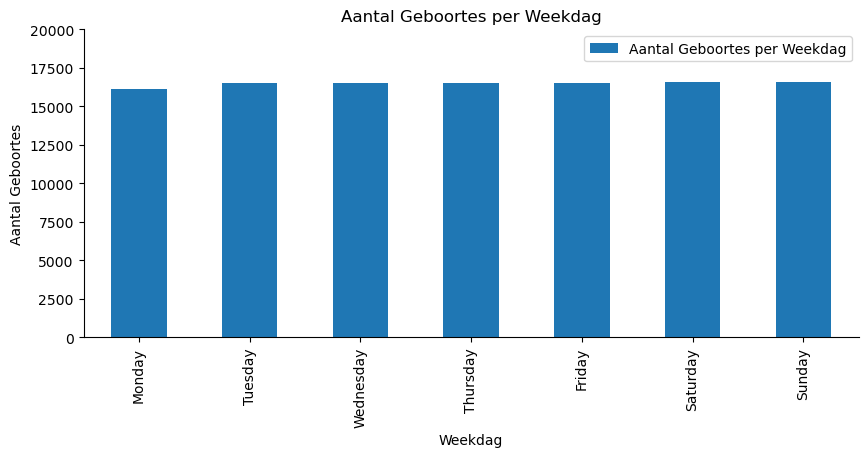

In [391]:
fig, ax = plt.subplots(figsize=(10, 4))

categories = ['Monday', 
              'Tuesday', 
              'Wednesday', 
              'Thursday', 
              'Friday', 
              'Saturday', 
              'Sunday']

# Convert 'Day of Week' to a categorical type
geboortes_correct['Day of Week'] = (pd.to_datetime(geboortes_correct['datum']).dt
                                                .day_name())
geboortes_correct['Day of Week'] = (pd.Categorical(geboortes_correct['Day of Week'], 
                                                   categories=categories, 
                                                   ordered=True))

# Now you can sort by 'Day of Week' and plot
(geboortes_correct.sort_values('Day of Week')
                    .groupby('Day of Week', observed = True)
                    .size()
                    .plot(kind='bar', ax=ax, label = 'Aantal Geboortes per Weekdag'))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Aantal Geboortes per Weekdag')
ax.set_xlabel('Weekdag')
ax.set_ylabel('Aantal Geboortes')
ax.set_ylim(0,20000)
ax.legend();